<a href="https://colab.research.google.com/github/yutaro-tanaka-yt2705/ag-cgan/blob/main/3_2_postprocessing_artificial_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [181]:
#Import our common libraries
import pandas as pd
import numpy as np
from numpy.random import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import gzip
import sys
import warnings
import timeit

In [182]:
#Import our DL libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers, layers
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, load_model, save_model, model_from_json
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from torch.optim import Adam
import torch.cuda as cuda
import torch.nn as nn
import torch
from torch.distributions import Normal

In [103]:
#Implement hyperparameters
class Hyperparameter:
    num_classes: int        = 5
    num_channels: int       = 1
    batchsize: int          = 32
    num_epochs: int         = 20
    latent_size: int        = 64
    n_critic: int           = 5
    critic_size: int        = 1024
    generator_size: int     = 1024
    critic_hidden_size: int = 1024
    gp_lambda: float        = 10.
    alpha: int              = 0.01
    d_lr: float             = 0.008
    g_lr: float             = 0.008
        
hp = Hyperparameter()

In [189]:
# implement generator
generator_model_filepath = '/content/drive/MyDrive/artificial_genome_project/cgan_models/199_generator/'
generator = tf.keras.models.load_model(generator_model_filepath)

In [193]:
# obtain artificial dataset
num_classes, ag_num = 5, 100
labels = np.asarray([x for _ in range(ag_num) for x in range(num_classes)])
labels = tf.cast(labels, dtype=tf.float32) 
labels = tf.expand_dims(labels, axis = -1)

latent_data = tf.random.normal(shape=(num_classes*ag_num, hp.latent_size+num_classes)) 
latent_labels = tf.concat([latent_data, labels], axis=1)
artificial_data = generator.predict(latent_data)
artificial_data_df = pd.DataFrame(artificial_data)
print(artificial_data.shape)
artificial_data_df['suppop_code'] = labels
artificial_data_df.head()

(500, 1000)


,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,suppop_code
0,0.209069,-0.021269,-0.178957,-0.138332,0.076834,0.022764,-0.165021,-0.047106,0.184904,0.217359,...,0.391935,0.233372,0.276328,-0.028802,0.119026,-0.012987,0.051556,0.156822,-0.064188,0.0
1,0.215509,0.247038,-0.491637,-0.074789,0.199187,-0.106778,-0.002955,0.156772,0.137891,-0.199903,...,0.194601,0.289467,-0.132666,0.174031,0.044245,0.028102,0.101615,0.060849,-0.183666,1.0
2,0.401864,-0.055614,-0.371631,0.069389,0.260162,0.055751,-0.108088,-0.165271,-0.014349,-0.104447,...,0.030680,0.265408,0.053107,0.100851,0.267469,-0.227435,0.174988,-0.051079,-0.161343,2.0
3,0.480217,-0.021314,-0.444264,0.124694,0.201602,-0.005182,-0.130082,-0.032544,0.195374,-0.123318,...,0.218010,0.239502,-0.105305,-0.026108,0.016826,-0.138610,-0.053299,-0.109010,-0.084364,3.0
4,-0.012895,0.161023,-0.517693,0.025135,0.483218,0.016698,0.081775,-0.038315,0.206102,-0.122185,...,-0.028912,0.379146,0.102374,0.077014,-0.122166,-0.058284,-0.016874,-0.221639,-0.268010,4.0


In [206]:
artificial_data_df.to_csv('/content/drive/MyDrive/artificial_genome_project/artificial_data/artificial_genomes_raw.csv', index=False)

In [194]:
#Import real data
real_data = pd.read_csv('/content/drive/MyDrive/artificial_genome_project/test_dataset.csv')
real_data.head()

,ID,pair,X_1343510_CA_C,X_2464340_G_A,X_844565_T_G,X_1443587_C_T,X_846946_A_G,X_155783945_C_T,X_2348441_C_T,X_1495791_C_G,...,X_1494970_G_A,X_2272724_A_C,X_2441570_T_C,X_1420810_T_C,X_719380_A_G,X_1115457_A_G,X_2449045_T_C,X_1165297_A_G,population_code,suppop_code
0,HG00096,A,0,0,0,1,0,1,1,1,...,0,1,0,0,0,0,0,1,10.0,3.0
1,HG00096,B,0,0,1,1,1,1,0,1,...,0,1,0,0,0,1,0,0,10.0,3.0
2,HG00097,A,0,0,1,1,1,1,0,1,...,0,0,0,1,0,0,0,0,10.0,3.0
3,HG00097,B,0,0,1,1,0,1,0,0,...,0,1,0,0,0,0,1,0,10.0,3.0
4,HG00099,A,0,0,1,1,1,1,0,0,...,0,1,1,1,0,0,1,0,10.0,3.0


In [198]:
#To make the initial test variant table, filter for 1000 most common SNPs. 
variant_info = pd.read_csv('/content/drive/MyDrive/artificial_genome_project/chrX_variant_info_formatted.csv')
variant_info['variant_code'] = (variant_info['CHROM'] + '_' +  variant_info['POS'].astype(str) + '_' + variant_info['REF'] + '_' + variant_info['ALT'])
variant_info = variant_info[variant_info.variant_code.isin(real_data[2:-2].columns)] 
print(variant_info.shape)
variant_info.head()

(1000, 12)


,CHROM,POS,REF,ALT,allele_count,allele_freq,eas_allele_freq,eur_allele_freq,afr_allele_freq,amr_allele_freq,sas_allele_freq,variant_code
43,X,23327,T,G,1232,0.24,0.17,0.04,0.60,0.05,0.18,X_23327_T_G
50,X,23971,G,A,1282,0.25,0.16,0.05,0.63,0.07,0.18,X_23971_G_A
54,X,25759,T,C,799,0.16,0.04,0.01,0.51,0.04,0.04,X_25759_T_C
73,X,26473,A,G,1261,0.25,0.16,0.04,0.63,0.06,0.17,X_26473_A_G
74,X,26492,C,G,1261,0.25,0.16,0.04,0.63,0.06,0.17,X_26492_C_G


In [234]:
pop_code_df = pd.read_csv('/content/drive/MyDrive/artificial_genome_project/population_code_table.csv')
pop_code_df['population_code'] = pop_code_df['population_code'].apply(lambda x: str(x).split('.')[0])
pop_code_df['suppop_code'] = pop_code_df['suppop_code'].apply(lambda x: str(x).split('.')[0])
pop_code_df.head()

,population_code,Population code,suppop_code,Superpopulation code
0,9,FIN,3,EUR
1,6,CHS,2,EAS
2,10,GBR,3,EUR
3,22,PUR,1,AMR
4,3,CDX,2,EAS


In [209]:
#postprocessing of the data
artificial_data_df_table = []
for idx in range(0, 1000):
    artificial_data_df_idx = []
    sorted_list = sorted(artificial_data_df[idx].tolist())
    variant_code = real_data.columns.tolist()[2:-2][idx]
    allele_freq = variant_info[variant_info['variant_code']==str(variant_code)].allele_freq.tolist()[0]
    cutoff_num = int(np.ceil(allele_freq * artificial_data_df.shape[0]))
    cutoff_val = sorted_list[cutoff_num]
    for item in artificial_data_df[idx].tolist():
      if item > cutoff_val:
        artificial_data_df_idx.append(1)
      else:
        artificial_data_df_idx.append(0)
    artificial_data_df_table.append(artificial_data_df_idx)
artificial_data_df_table = pd.DataFrame(artificial_data_df_table).T
artificial_data_df_table.columns = real_data.columns.tolist()[2:-2]
artificial_data_df_table['suppop_code'] = artificial_data_df['suppop_code'].tolist()

In [210]:
artificial_data_df_table.head()

,X_1343510_CA_C,X_2464340_G_A,X_844565_T_G,X_1443587_C_T,X_846946_A_G,X_155783945_C_T,X_2348441_C_T,X_1495791_C_G,X_2452743_G_T,X_844299_C_T,...,X_1494541_A_G,X_1494970_G_A,X_2272724_A_C,X_2441570_T_C,X_1420810_T_C,X_719380_A_G,X_1115457_A_G,X_2449045_T_C,X_1165297_A_G,suppop_code
0,0,1,1,0,0,1,0,0,1,1,...,1,0,1,1,1,1,1,1,1,0.0
1,0,1,0,0,0,0,1,1,1,0,...,1,1,0,1,1,1,1,1,1,1.0
2,1,0,1,0,1,1,1,0,0,0,...,0,1,1,1,1,0,1,0,1,2.0
3,1,1,0,1,0,0,1,0,1,0,...,1,0,0,1,0,0,0,0,1,3.0
4,0,1,0,0,1,0,1,0,1,0,...,0,1,1,1,0,1,0,0,1,4.0


In [211]:
artificial_data_df_table.to_csv('/content/drive/MyDrive/artificial_genome_project/artificial_data/artificial_genomes_processed.csv', index=False)

## Check for Security Leaks

In [221]:
#check for similarities
from scipy.spatial.distance import cdist

val_out = 1 - cdist(artificial_data_df_table.iloc[:, :-1], real_data.iloc[:, 2:-2], 'cosine')

In [227]:
val_out.min(), val_out.max(), val_out.mean()

(0.24724690725256515, 0.6126533914559394, 0.44309643121577197)

## Identify Poorly Correlating Variants

In [231]:
#obtain table of allele frequencies by population for artificial data
variants = real_data.columns.tolist()[2:-2]
artificial_allele_freq = []
for i in range(5):
  artificial_allele_freq_pop = []
  filtered_df = artificial_data_df_table[artificial_data_df_table.suppop_code == i]
  for var in variants:
      var_count = filtered_df[var].sum()
      var_freq = var_count / 100
      artificial_allele_freq_pop.append(var_freq)
  artificial_allele_freq.append(artificial_allele_freq_pop)
artificial_allele_freq = pd.DataFrame(artificial_allele_freq, columns=variants)

In [ ]:
##EUR: 3, EAS: 2, AFR:0, AMR: 1, SAS:4

In [257]:
real_eurs = []
fake_eurs = []
real_eass = []
fake_eass = []
real_afrs = []
fake_afrs = []
real_amrs = []
fake_amrs = []
real_sass = []
fake_sass = []

for var in variants:
  #europe
  real_eur = variant_info[variant_info.variant_code==var]['eur_allele_freq'].tolist()[0]
  fake_eur = 1- artificial_allele_freq[var].tolist()[3]
  #east asia
  real_eas = variant_info[variant_info.variant_code==var]['eas_allele_freq'].tolist()[0]
  fake_eas = 1- artificial_allele_freq[var].tolist()[2]
  #africa
  real_afr = variant_info[variant_info.variant_code==var]['afr_allele_freq'].tolist()[0]
  fake_afr = 1- artificial_allele_freq[var].tolist()[0]
  #america
  real_amr = variant_info[variant_info.variant_code==var]['amr_allele_freq'].tolist()[0]
  fake_amr = 1- artificial_allele_freq[var].tolist()[1]
  #south asia
  real_sas = variant_info[variant_info.variant_code==var]['sas_allele_freq'].tolist()[0]
  fake_sas = 1- artificial_allele_freq[var].tolist()[4]
  
  real_eurs.append(real_eur)
  fake_eurs.append(fake_eur)
  real_eass.append(real_eas)
  fake_eass.append(fake_eas)
  real_afrs.append(real_afr)
  fake_afrs.append(fake_afr)
  real_amrs.append(real_amr)
  fake_amrs.append(fake_amr)
  real_sass.append(real_sas)
  fake_sass.append(fake_sas)

[]

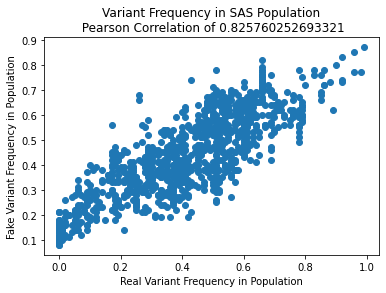

In [269]:
from scipy.stats import pearsonr
plt.scatter(real_sass, fake_sass)
plt.xlabel('Real Variant Frequency in Population')
plt.ylabel('Fake Variant Frequency in Population')
plt.title('Variant Frequency in SAS Population'+'\n Pearson Correlation of '+str(pearsonr(real_sass, fake_sass)[0]))
plt.plot()


In [232]:
artificial_allele_freq.head()

,X_1343510_CA_C,X_2464340_G_A,X_844565_T_G,X_1443587_C_T,X_846946_A_G,X_155783945_C_T,X_2348441_C_T,X_1495791_C_G,X_2452743_G_T,X_844299_C_T,...,X_484011_A_G,X_1494541_A_G,X_1494970_G_A,X_2272724_A_C,X_2441570_T_C,X_1420810_T_C,X_719380_A_G,X_1115457_A_G,X_2449045_T_C,X_1165297_A_G
0,0.55,0.75,0.59,0.23,0.52,0.30,0.57,0.42,0.55,0.50,...,0.69,0.61,0.62,0.44,0.64,0.61,0.76,0.75,0.46,0.82
1,0.59,0.74,0.45,0.23,0.53,0.31,0.59,0.51,0.61,0.57,...,0.83,0.73,0.73,0.36,0.80,0.68,0.69,0.72,0.36,0.90
2,0.58,0.70,0.52,0.16,0.45,0.30,0.56,0.46,0.55,0.49,...,0.78,0.67,0.71,0.49,0.72,0.56,0.71,0.64,0.47,0.86
3,0.62,0.70,0.51,0.24,0.48,0.29,0.65,0.48,0.63,0.46,...,0.70,0.70,0.62,0.43,0.73,0.57,0.72,0.67,0.46,0.74
4,0.55,0.70,0.52,0.23,0.56,0.34,0.72,0.42,0.55,0.47,...,0.64,0.63,0.66,0.37,0.60,0.52,0.71,0.76,0.34,0.77


-----

# Archive

In [ ]:
# create artificial genome dataset
generator_model_filepath = '/content/drive/MyDrive/artificial_genome_project/cgan_models/199_generator/'
generator = tf.keras.models.load_model(generator_model_filepath)

num_classes = 5
# latent data
ag_num = 100

for class_idx in range(num_classes):
    label = keras.utils.to_categorical(class_idx, num_classes)
    label = label[:, None]
    label = tf.repeat(label, repeats=[ag_num])
    label = tf.reshape(
            label, (-1, ag_num, hp.num_classes) #prepare labels to be concat with variant data.
            )
    label = tf.squeeze(label)
    label = tf.cast(label, tf.float32)

    latent_data = tf.random.normal(shape=(ag_num, hp.latent_size)) 
    latent_labels = tf.concat([latent_data, label], axis=1)

    artificial_data = generator.predict(latent_labels)
    artificial_data_df = pd.DataFrame(artificial_data)

    artificial_data_df.to_csv('/content/drive/MyDrive/artificial_genome_project/artificial_data/new_model/artificial_genome_'+str(class_idx)+'.csv', index=False)